In [93]:
import pickle

import pandas as pd
import numpy as np

#sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

import matplotlib.pyplot as plt




In [ ]:
# 3:45 pm 6 pm

In [12]:
with open('data/used_query_terms.pkl', 'rb') as f:
    query_terms = pickle.load(f)
    
# terms

In [8]:
text_df = pd.read_pickle('data/data_frame_no_paper.pkl')

vectorize the text

In [13]:
# query_terms
vect_binary = CountVectorizer(binary = True, vocabulary = query_terms)
vect_freq   = CountVectorizer(binary = False, vocabulary = query_terms)
vect_tfidf  = TfidfVectorizer(vocabulary = query_terms)

binary_overlap_vectors = vect_binary.fit_transform(text_df['all_text'])
freq_overlap_vectors = vect_freq.fit_transform(text_df['all_text'])
tfidf_overlap_vectors = vect_tfidf.fit_transform(text_df['all_text'])

In [14]:
binary_overlap_vectors = [vec for vec in binary_overlap_vectors.toarray()]
freq_overlap_vectors = [vec for vec in freq_overlap_vectors.toarray()]
tfidf_overlap_vectors = [vec for vec in tfidf_overlap_vectors.toarray()]

In [15]:
overlap_df = text_df['title'].to_frame()
overlap_df = overlap_df.assign(all_text = text_df['all_text'])
overlap_df = overlap_df.assign(binary_vector = binary_overlap_vectors)
overlap_df = overlap_df.assign(freq_vector = freq_overlap_vectors)
overlap_df = overlap_df.assign(tfidf_vector = tfidf_overlap_vectors)

relevant_vec = []
for val in text_df['relevant'].values:
    if val == True:
        relevant_vec.append(1)
    else:
        relevant_vec.append(0)
overlap_df = overlap_df.assign(relevant = relevant_vec)

overlap_df = overlap_df.sample(frac=1).reset_index(drop=True)

In [20]:
train, validate, test = np.split(overlap_df.sample(frac=1), [int(.6*len(overlap_df)), int(.8*len(overlap_df))])

binary_vectors_valid = validate['binary_vector'].tolist()
binary_vectors_train = train['binary_vector'].tolist()
binary_vectors_test = test['binary_vector'].tolist()

freq_vectors_valid = validate['freq_vector'].tolist()
freq_vectors_train = train['freq_vector'].tolist()
freq_vectors_test = test['freq_vector'].tolist()

tfidf_vectors_valid = validate['tfidf_vector'].tolist()
tfidf_vectors_train = train['tfidf_vector'].tolist()
tfidf_vectors_test = test['tfidf_vector'].tolist()



y_valid = validate['relevant'].values
y_train = train['relevant'].values
y_test = test['relevant'].values


In [131]:
clf = BernoulliNB(fit_prior = False, alpha=.005)
y_pred = clf.fit(binary_vectors_valid, y_valid)
probs = y_pred.predict_proba(binary_vectors_valid).tolist()
probs = [prob[0] for prob in probs]

pred = clf.predict(binary_vectors_test)

In [132]:
sum(y_valid) + sum(y_test) + sum(y_train)

277

In [133]:
# the tuples in prob_with_class represent the probability the paper was not relevant (class 0) and it's predicted class


prob_with_class = list(zip(probs, y_valid))
prob_with_class.sort(reverse = True)
# prob_with_class
pos_probs = [tup[0] for tup in prob_with_class if tup[1]==1]
neg_probs = [tup[0] for tup in prob_with_class if tup[1]==0]

we'll create a histogram to see how the data is distributed

In [134]:
neg = pd.Series(neg_probs)
pos = pd.Series(pos_probs)

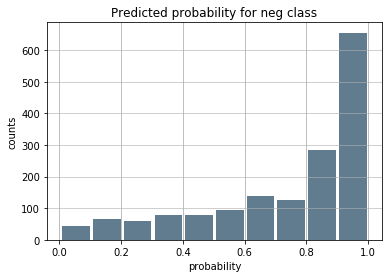

In [135]:
neg.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.title('Predicted probability for neg class')
plt.xlabel('probability')
plt.ylabel('counts')
plt.grid(axis='y', alpha=0.75)

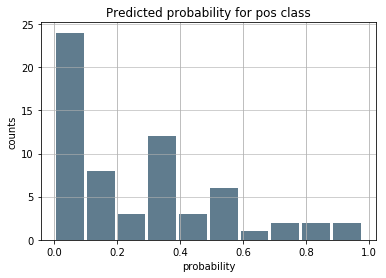

In [136]:
pos.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.title('Predicted probability for pos class')
plt.xlabel('probability')
plt.ylabel('counts')
plt.grid(axis='y', alpha=0.75)

C:\Users\Tanner\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


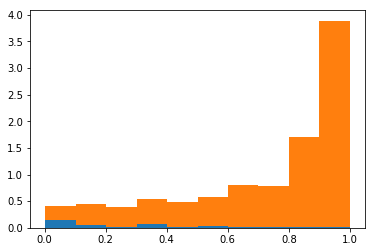

In [137]:
plt.figure()
plt.hist([pos, neg], 10, stacked=True, normed = True)
plt.show()

In [138]:
cutoff = .9
num_pos = 0
num_neg = 0

for prob in prob_with_class:
#     print(prob)
    if prob[0] > cutoff:
        if prob[1]==1:
            num_pos+=1
#             print(prob)
        else:
#             print(prob)
            num_neg+=1
    else:
        print("remove {} out of {} positive({}%) and {} out of {} negative({}%) at cutoff {}\n".format(num_pos, len(pos),np.around(num_pos/len(pos)*100, 3) ,num_neg, len(neg), np.around(num_neg/len(neg)*100, 3),np.around(cutoff, 2)))
        cutoff -=.1

remove 1 out of 63 positive(1.587%) and 656 out of 1629 negative(40.27%) at cutoff 0.9

remove 4 out of 63 positive(6.349%) and 938 out of 1629 negative(57.581%) at cutoff 0.8

remove 5 out of 63 positive(7.937%) and 1069 out of 1629 negative(65.623%) at cutoff 0.7

remove 7 out of 63 positive(11.111%) and 1201 out of 1629 negative(73.726%) at cutoff 0.6

remove 13 out of 63 positive(20.635%) and 1292 out of 1629 negative(79.312%) at cutoff 0.5

remove 16 out of 63 positive(25.397%) and 1371 out of 1629 negative(84.162%) at cutoff 0.4

remove 28 out of 63 positive(44.444%) and 1451 out of 1629 negative(89.073%) at cutoff 0.3

remove 31 out of 63 positive(49.206%) and 1512 out of 1629 negative(92.818%) at cutoff 0.2

remove 39 out of 63 positive(61.905%) and 1578 out of 1629 negative(96.869%) at cutoff 0.1



If we remove the papers whose predicted probability of the negative class is greater 0.6, we cut out 73% of non relevant papers and only 11% of the relevant ones!!!!

# do some cross validation, try with tf_idf